### Initialize Software Environment

In [100]:
from datetime import datetime
from dateutil.parser import parse
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
from wordcloud import WordCloud
%matplotlib inline

### Define functions

In [2]:
def format_date(date):
    """ Transforms a 2-digit year into 4-digit year. 
    
    The "Economic News Article Tone and Relevance" open data set published
    by CrowdFlower contains data from 1951 to 2014.
    https://www.crowdflower.com/data-for-everyone/
    
    Args:
        String that contains a date in the MM/DD/YY format.
    
    Returns:
        String that contains a date in the MM/DD/YYYY format"""
    [month, day, year] = [int(elem) for elem in date.split("/")]

    if year > 14:
        year = 1900 + year
    else:
        year = 2000 + year
        
    return datetime(year, month, day)

def compute_decade(year):
    """ Computes the decade that a year falls within
    
    Args:
        year: Integer that stores the year
    
    Returns:
        decade: decade that a year falls within"""
    if year < 2000:
        century = 1900
    else:
        century = 2000

    return np.int(10 * np.floor(float(year - century) / 10)) + century 

### Download & clean data

In [3]:
data_dir = "./Data"

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

csv_file_path = os.path.join(data_dir, "fullEconomicNews.csv")

if not os.path.exists(csv_file_path):
    csv_file_url = os.path.join("https://www.crowdflower.com/wp-content",
                                "uploads/2016/03",
                                "Full-Economic-News-DFE-839861.csv")

    news_article_df = pd.read_csv(csv_file_url)

    news_article_df = news_article_df.rename(columns = lambda elem: re.sub("[_:]","",elem))

    news_article_df["date"] = news_article_df["date"].apply(format_date)
    
    news_article_df["year"] = [elem.year for elem in news_article_df["date"]]
    
    news_article_df["decade"] = news_article_df["year"].apply(compute_decade)

    news_article_df.to_csv(csv_file_path)
else:
    news_article_df = pd.read_csv(csv_file_path)

### Compute the number of relevant and non-relevant documents / decade
-[Transform output of groupby() into a DataFrame](http://stackoverflow.com/questions/10373660/converting-a-pandas-groupby-object-to-dataframe)

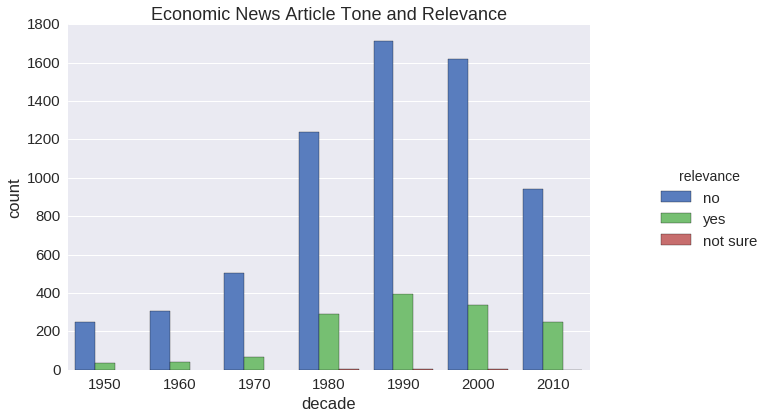

In [4]:
decade_relevance_df = news_article_df.groupby(['decade','relevance']).size()

decade_relevance_df = decade_relevance_df.reset_index()

decade_relevance_df = decade_relevance_df.rename(columns={0: 'count'})

sns.set(font_scale=1.5)
g = sns.factorplot(x="decade",
                   y="count",
                   hue="relevance",
                   data=decade_relevance_df,
                   size=6,
                   kind="bar",
                   palette="muted")
g.fig.set_figwidth(12)
g.ax.set_title("Economic News Article Tone and Relevance")
plt.savefig("./decade_relevance.png")

### Compute the distribution of positive and negative sentiment documents
-[Fix 'A Value is trying to be set on a copy of a slice from a DataFrame' Pandas warning](http://stackoverflow.com/questions/32675861/copy-all-values-in-a-column-to-a-new-column-in-a-pandas-dataframe)

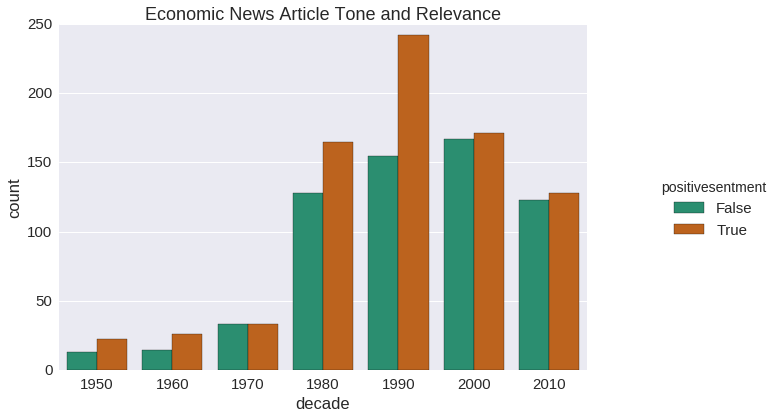

In [5]:
relevant_articles = news_article_df[news_article_df["relevance"] == "yes"].copy()
 
median_positivity = np.median(relevant_articles['positivity'])

relevant_articles.loc[:,"positivesentment"] =\
    relevant_articles['positivity'].apply(lambda elem: elem >= median_positivity)
    
decade_positive_df = relevant_articles.groupby(['decade','positivesentment']).size()

decade_positive_df = decade_positive_df.reset_index()

decade_positive_df = decade_positive_df.rename(columns={0: 'count'})

sns.set(font_scale=1.5)
g = sns.factorplot(x="decade",
                   y="count",
                   hue="positivesentment",
                   data=decade_positive_df,
                   size=6,
                   kind="bar",
                   palette="Dark2")
g.fig.set_figwidth(12)
g.ax.set_title("Economic News Article Tone and Relevance")
plt.savefig("./decade_positivesentment.png")

# Generate word clouds for relevant & non-relevant documents from the 1990's
-[Rule of thumb for splitting data into training & test data sets](http://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio)  
-[Stratified sampling of a Pandas DataFrame Column](http://stackoverflow.com/questions/36997619/sklearn-stratified-sampling-based-on-a-column)

In [9]:
news_articles1990_df = news_article_df[news_article_df["decade"] == 1990].copy()

news_articles1990_df = news_articles1990_df[news_articles1990_df["relevance"] != "not sure"]

relevance = news_articles1990_df["relevance"].copy()

(train_news,
 test_news,
 train_relevance,
 test_relevance) = train_test_split(news_articles1990_df,
                                    relevance,
                                    train_size = 0.8,
                                    random_state=1214545101,
                                    stratify=relevance)

### Define function to clean text

- [Remove HTML tags](http://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element)
- [Remove stopwords](http://stackoverflow.com/questions/5486337/how-to-remove-stop-words-using-nltk-or-python)
- [Tokenize sentance](http://www.nltk.org/book/ch03.html)
- [Remove punctuation](http://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python)
- [Define translation to remove punctuation](http://codereview.stackexchange.com/questions/110419/removing-punctuation-and-lowercasing-a-string)

In [67]:
def clean_text(raw_text):
    """ Performs the following operations on a string:
    
    1.) Remove HTML tags
    2.) Transform to lowercase & remove punctuation
    3.) Remove numbers
    
    Args:
        raw_text: Input string
    
    Returns:
        clean_text: Output string"""
    soup = BeautifulSoup(raw_text, "html.parser") 

    clean_text = soup.getText(separator=' ')

    clean_text = clean_text.translate(str.maketrans("", "", string.punctuation))

    tokens = [elem.lower() for elem in word_tokenize(clean_text) if elem not in stopwords.words('english')]

    matchobj = re.compile("[0-9]+")

    tokens = [elem for elem in tokens if matchobj.match(elem) == None]

    return " ".join(tokens)

### Generate a wordcloud of the non-relevant document headlines
- [Iterate over Pandas DataFrame rows](http://stackoverflow.com/questions/10729210/iterating-row-by-row-through-a-pandas-dataframe)
- [Find the index of a string in a list](http://stackoverflow.com/questions/176918/finding-the-index-of-an-item-given-a-list-containing-it-in-python)
- [Concatenating strings](http://www.pythonforbeginners.com/concatenation/string-concatenation-and-formatting-in-python)  
- [WordCloud library](https://github.com/amueller/word_cloud)

In [117]:
nonrelevant_train_df = train_news[train_news["relevance"] == "no"].copy()

headline_index = list(nonrelevant_train_df.columns).index("headline")

nonrelevant_headline_text = ""

for row in nonrelevant_train_df.iterrows():
    nonrelevant_headline_text += clean_text(row[1][headline_index]) + " "

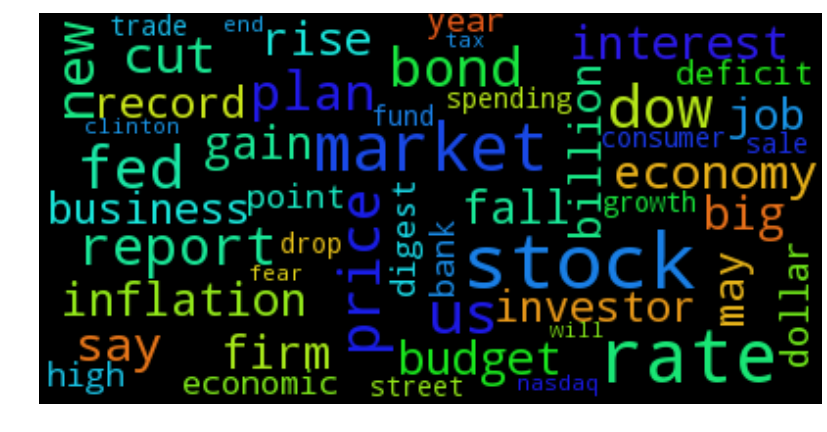

In [118]:
wordcloud = WordCloud(max_font_size=40,
                      relative_scaling=.5,
                      max_words=50).generate(nonrelevant_headline_text)
plt.figure(figsize=(14,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('nonRelevantArticleHeadingWC.png')

### Generate a wordcloud of the relevant document headlines

In [105]:
relevant_train_df = train_news[train_news["relevance"] == "yes"].copy()

relevant_headline_text = ""

for row in relevant_train_df.iterrows():
    relevant_headline_text += clean_text(row[1][headline_index]) + " "

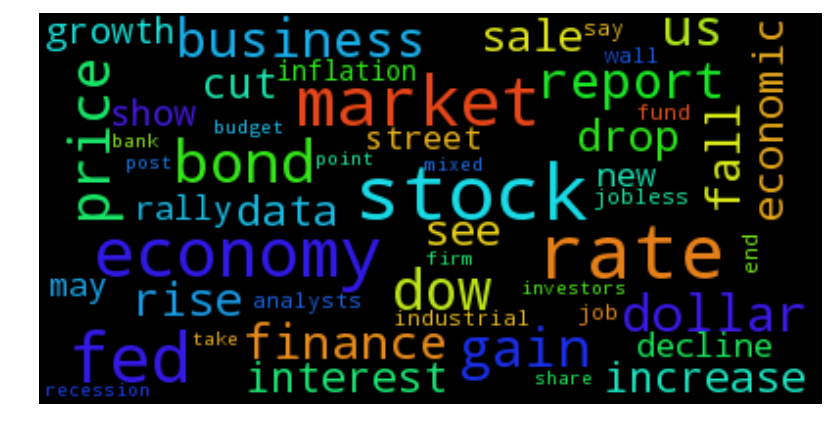

In [124]:
wordcloud = WordCloud(max_font_size=40,
                      relative_scaling=.5,
                      max_words=50).generate(relevant_headline_text)
plt.figure(figsize=(14,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('relevantArticleHeadingWC.png')

### Generate a word cloud for non-relevant document text

In [121]:
text_index = list(nonrelevant_train_df.columns).index("text")

nonrelevant_text = ""

for row in nonrelevant_train_df.iterrows():
    nonrelevant_text += clean_text(row[1][text_index]) + " "

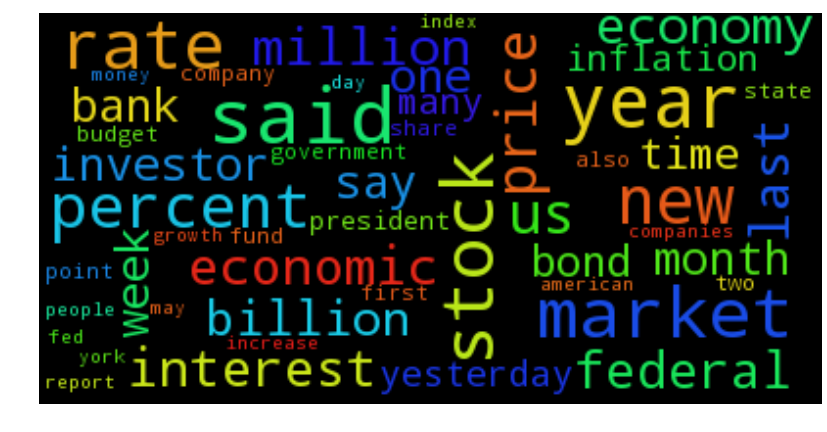

In [122]:
wordcloud = WordCloud(max_font_size=40,
                      relative_scaling=.5,
                      max_words=50).generate(nonrelevant_text)
plt.figure(figsize=(14,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('nonRelevantArticleWC.png')

### Generate a word cloud for relevant document text

In [123]:
relevant_text = ""

for row in relevant_train_df.iterrows():
    relevant_text += clean_text(row[1][text_index]) + " "

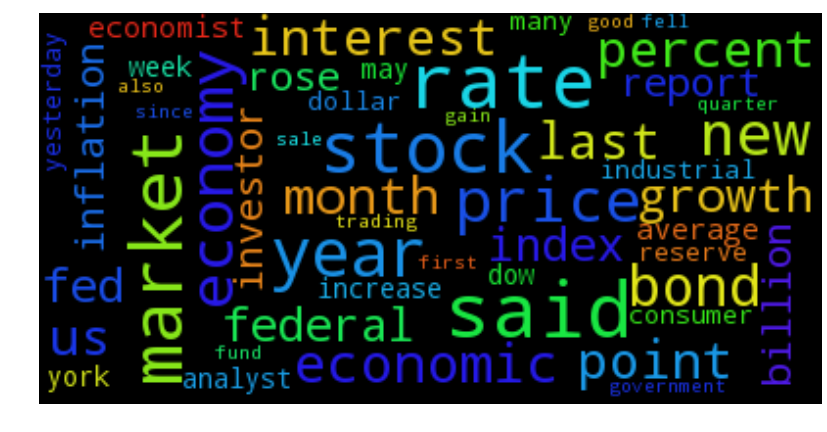

In [126]:
wordcloud = WordCloud(max_font_size=40,
                      relative_scaling=.5,
                      max_words=50).generate(relevant_text)
plt.figure(figsize=(14,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('relevantArticleWC.png')